# 3. Pruning Crossvalidation

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
# generate synthetic data
x = np.linspace(start = 0, stop = 2 * np.pi, num=500)
m = 2 * np.sin(x)
y = m + np.random.normal(loc = 0, scale = 1, size = len(x))

In [3]:
# adding column name to array (and transforming it into pd.DataFrame)
x = pd.DataFrame({'feature_1':x})
y = pd.DataFrame({'y':y})

In [21]:
# fit a very deep tree
deep_tree = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = 0).fit(x, y)
y_deep_tree = deep_tree.predict(x)

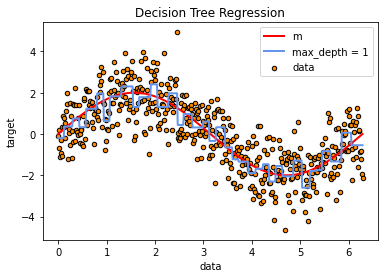

In [22]:
# Plot deep_tree
plt.figure()
plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data") # plot raw data (including stoch. desturbance)
plt.plot(x, m, color="red", label="m", linewidth=2) # plot raw data (excluding stoch. desturbance)
plt.plot(x, y_deep_tree, color="cornflowerblue", label="max_depth = 1", linewidth=2) # depth 1
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### 3.1 Impurity of leaves vs effective alphas of pruned tree

In [23]:
path = deep_tree.cost_complexity_pruning_path(x, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

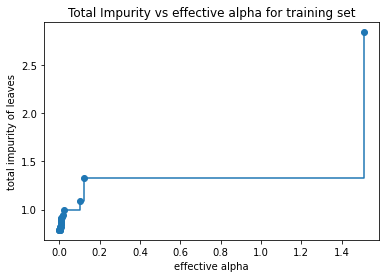

In [24]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [25]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = ccp_alpha).fit(x, y)
    clfs.append(clf)

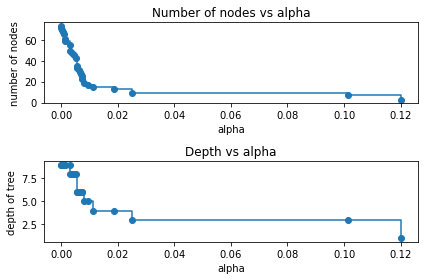

In [26]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

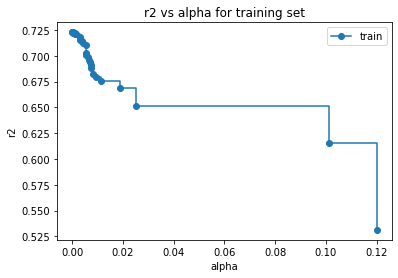

In [28]:
train_scores = [clf.score(x, y) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("r2")
ax.set_title("r2 vs alpha for training set")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
#ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#        drawstyle="steps-post")
ax.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    regr_dt = tree.DecisionTreeRegressor(max_depth = 30,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = ccp_alpha).fit(x, y)
    
    predictions = regr_dt.predict(x)
    cvs = np.mean(cross_val_score(regr_dt, x, y, cv = 10, scoring='r2'))
    node_counts = regr_dt.tree_.node_count
    depth = regr_dt.tree_.max_depth
    
    alpha_loop_values.append([ccp_alpha, node_counts, depth,
                              cvs])
              
alpha_results = pd.DataFrame(alpha_loop_values, 
                         columns=['alpha', 'node_counts', 'depth',
                                  'cvs'])

best_alpha = float(alpha_results[alpha_results.cvs == alpha_results.cvs.max()].alpha)
print(f'best alpha: {best_alpha}')

TypeError: cannot convert the series to <class 'float'>

In [30]:
alpha_results

,alpha,node_counts,depth,cvs
0,0.000000,73,9,-0.410308
1,0.000021,71,9,-0.410308
2,0.000170,69,9,-0.410308
3,0.000520,67,9,-0.410308
4,0.001054,65,9,-0.400043
5,0.001243,61,9,-0.400043
6,0.001511,59,9,-0.400043
7,0.003021,55,9,-0.400043
8,0.003213,49,8,-0.400043
9,0.003945,47,8,-0.351382


In [ ]:
regr_dt = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = best_alpha).fit(x, y)
y_deep_tree = deep_tree.predict(x)

In [ ]:
# Plot deep_tree
plt.figure()
plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data") # plot raw data (including stoch. desturbance)
plt.plot(x, m, color="red", label="m", linewidth=2) # plot raw data (excluding stoch. desturbance)
plt.plot(x, y_deep_tree, color="cornflowerblue", label="max_depth = 1", linewidth=2) # depth 1
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()